At now the data is item-customer-centric and I need a customer-centric data to solve the customer segmentation problem, that means to transform the actual dataset to a new one where each row represents a unique customer whose attributes are listed in other columns.

Another challenge is, the description is the only indicator of a product. To solve this problem, I'll cluster product descriptions into a few groups (4 or 5). The values of each one will indicate the total value of the items a customer bought that fit into the respective group.

# Basic cleaning

In [1]:
import pandas as pd

data = pd.read_csv('./data/data.csv', encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# Looking at how many unique customers there are
data['CustomerID'].nunique()

4372

In [3]:
# And how many customer rows have a NA value
data['CustomerID'].isna().value_counts()

False    406829
True     135080
Name: CustomerID, dtype: int64

In [4]:
# Due to this column is the most important and to fill all the missing values could be inaccurate I decide to drop all rows that have NA values
data = data.dropna()

print(data.shape)
data.head()

(406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# For this exercise the InvoiceNo and StockCode columns are irrelevant
data.drop(['InvoiceNo','StockCode'],axis=1,inplace=True)
data.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
# To prepare the Description column for vectorizing, I'll need to make the words lowercase and remove any punctuaction
data['Description'] = data['Description'].str.replace(r'[^\w\s]','',regex=True).str.lower()
data.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,white hanging heart tlight holder,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,red woolly hottie white heart,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
# In the future I'll need to know the total amount of monet spent on a product
data['Total'] = data['UnitPrice'] * data['Quantity']

mask = (data['Quantity'].lt(6000)) & (data['Quantity'].gt(-6000)) & (data['Total'].lt(20000)) & (data['Total'].gt(-20000))
data = data.loc[mask]

data = data.reset_index().drop('index',axis=1)

# Vectorizing the Description

Given the nature of these descriptions, it's probably best to use bag of words instead of TD-IDF. It seems that every word in the description is a keyword of sorts, so vectorizing it simply with bag of words/count is the best way to go.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')

In [9]:
descriptions = vectorizer.fit_transform(data['Description'])
descriptions.get_shape()

(406821, 2092)

# Cluster the Products and Create Product Features

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(descriptions)

KMeans(n_clusters=5)

In [11]:
data['Product'] = kmeans.labels_
data.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Product
0,white hanging heart tlight holder,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,1
1,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,1
2,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,1
3,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,1
4,red woolly hottie white heart,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,4


### And now it's time to create the customer-centric data

In [12]:
import numpy as np
custom1 = data.pivot_table(values='Total',index='CustomerID', columns='Product', aggfunc=np.sum)
custom1.head()

Product,0,1,2,3,4
CustomerID,,,,,
12347.0,408.90,2796.26,105.80,459.7,539.34
12348.0,524.60,1230.88,41.76,NaN,NaN
12349.0,244.87,1145.48,138.15,NaN,229.05
12350.0,NaN,299.00,20.40,NaN,15.00
12352.0,257.60,1214.61,NaN,NaN,73.20


In [13]:
custom1.fillna(value=0, inplace=True)
custom1.head()

Product,0,1,2,3,4
CustomerID,,,,,
12347.0,408.90,2796.26,105.80,459.7,539.34
12348.0,524.60,1230.88,41.76,0.0,0.00
12349.0,244.87,1145.48,138.15,0.0,229.05
12350.0,0.00,299.00,20.40,0.0,15.00
12352.0,257.60,1214.61,0.00,0.0,73.20


In [14]:
customers = pd.DataFrame({'CustomerID' : data['CustomerID'].unique()})
customers.sort_values(by='CustomerID',inplace=True)
customers.reset_index(drop=True,inplace=True)
customers.head()

,CustomerID
0,12347.0
1,12348.0
2,12349.0
3,12350.0
4,12352.0


In [15]:
customers = customers.assign(
    Products0 = custom1[0].values,
    Products1 = custom1[1].values,
    Products2 = custom1[2].values,
    Products3 = custom1[3].values,
    Products4 = custom1[4].values
)
customers.head()

,CustomerID,Products0,Products1,Products2,Products3,Products4
0,12347.0,408.90,2796.26,105.80,459.7,539.34
1,12348.0,524.60,1230.88,41.76,0.0,0.00
2,12349.0,244.87,1145.48,138.15,0.0,229.05
3,12350.0,0.00,299.00,20.40,0.0,15.00
4,12352.0,257.60,1214.61,0.00,0.0,73.20


# Creating Purchasing History Descriptions

In [16]:
custom2 = data.groupby(by='CustomerID')['Total'].agg(['count','min','max','mean','sum'])
custom2.head()

,count,min,max,mean,sum
CustomerID,,,,,
12347.0,182,5.04,249.6,23.681319,4310.00
12348.0,31,13.20,240.0,57.975484,1797.24
12349.0,73,6.64,300.0,24.076027,1757.55
12350.0,17,8.50,40.0,19.670588,334.40
12352.0,95,-376.50,376.5,16.267474,1545.41


In [17]:
customers = customers.assign(
    PurchaseCount = custom2['count'].values,
    PurchaseMin = custom2['min'].values,
    PurchaseMax = custom2['max'].values,
    PurchaseMean = custom2['mean'].values,
    PurchaseSum = custom2['sum'].values
)
customers.head()

,CustomerID,Products0,Products1,Products2,Products3,Products4,PurchaseCount,PurchaseMin,PurchaseMax,PurchaseMean,PurchaseSum
0,12347.0,408.90,2796.26,105.80,459.7,539.34,182,5.04,249.6,23.681319,4310.00
1,12348.0,524.60,1230.88,41.76,0.0,0.00,31,13.20,240.0,57.975484,1797.24
2,12349.0,244.87,1145.48,138.15,0.0,229.05,73,6.64,300.0,24.076027,1757.55
3,12350.0,0.00,299.00,20.40,0.0,15.00,17,8.50,40.0,19.670588,334.40
4,12352.0,257.60,1214.61,0.00,0.0,73.20,95,-376.50,376.5,16.267474,1545.41


# Creating a binary 'Foreign' feature

In [18]:
foreign_c = -data['Country'].isin(['United Kingdom'])
foreign_c = foreign_c.astype('int')

data['Foreign'] = foreign_c
data.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Product,Foreign
0,white hanging heart tlight holder,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,1,0
1,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,1,0
2,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,1,0
3,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,1,0
4,red woolly hottie white heart,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,4,0


In [19]:
customers['Foreign'] = data.groupby('CustomerID')['Foreign'].mean().astype('int').values
customers.head()

,CustomerID,Products0,Products1,Products2,Products3,Products4,PurchaseCount,PurchaseMin,PurchaseMax,PurchaseMean,PurchaseSum,Foreign
0,12347.0,408.90,2796.26,105.80,459.7,539.34,182,5.04,249.6,23.681319,4310.00,1
1,12348.0,524.60,1230.88,41.76,0.0,0.00,31,13.20,240.0,57.975484,1797.24,1
2,12349.0,244.87,1145.48,138.15,0.0,229.05,73,6.64,300.0,24.076027,1757.55,1
3,12350.0,0.00,299.00,20.40,0.0,15.00,17,8.50,40.0,19.670588,334.40,1
4,12352.0,257.60,1214.61,0.00,0.0,73.20,95,-376.50,376.5,16.267474,1545.41,1


In [20]:
customers['Foreign'].value_counts()

0    3948
1     422
Name: Foreign, dtype: int64

In [24]:
data.to_csv('./data/new_data.csv',index=False)
customers.to_csv('./data/customers.csv',index=False)

<AxesSubplot:xlabel='Quantity', ylabel='Total'>

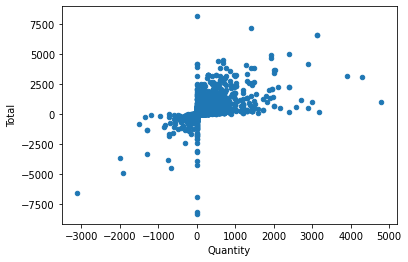

In [21]:
data.plot.scatter(x='Quantity', y='Total')

In [23]:
data['Product'].value_counts()

2     17641
3     31492
4     31795
0     46736
1    279157
Name: Product, dtype: int64